$\textbf{Introduction}$
In this section we will examine how well a simple feedforward network performs against a polynominal function for fitting very complex functions.  We will work with artificially-generated data.

$\textbf{Simple Example}$: Approximating a Sine and Exponential Function

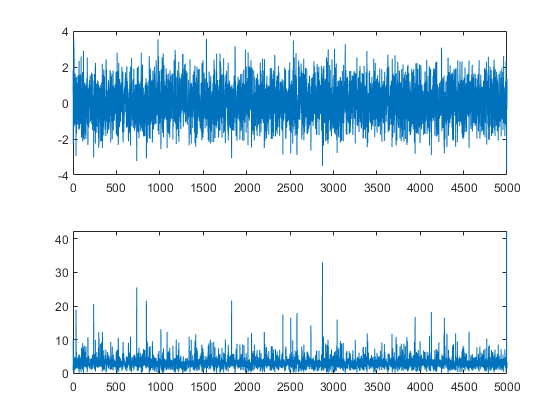

In [1]:
x = randn(5000,1);
y = cos(x)+ exp(-x)+ exp(randn(5000,1)* .1);
subplot(211); plot(x); subplot(212); plot(y);

We see an apparantly random series generating data which exhibit several jump periods.  Suppose we do not know the true generating funciton?  How can be best fit the observed series to the exogenous observed series x?   First lets do a cubic polynomial fit.

In [33]:
x1 =  normalize(x,'zscore','robust'); 
y1 = normalize(y,'zscore','robust');
pfit = polyfit(x1,y1,3);
yhat_poly = polyval(pfit,x1);
RSQ_poly= var(yhat_poly)/var(y1)
SSE_poly =  (y1-yhat_poly)'*(y1-yhat_poly);
nst = [2];
[yhat_net, RSQ_net,yy] = NNFFfun(x1,y1,nst);
ehat_net = yy - yhat_net;

RSQ_net2 = var(yhat_net)/var(yy)
SSE_net = (yy-yhat_net)'*(yy-yhat_net);
Ratio = SSE_net/SSE_poly



RSQ_poly =

    0.9390


RSQ_net2 =

    0.9899


Ratio =

    0.0543




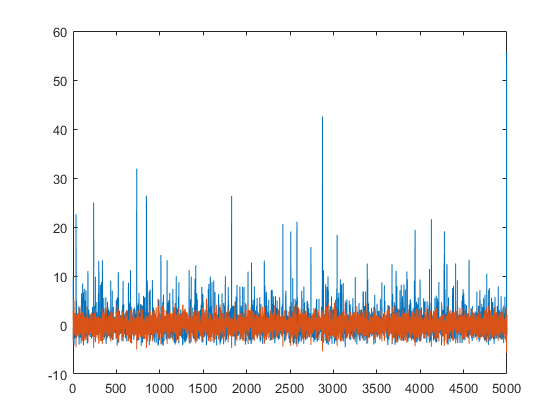

In [30]:
plot([y1 yy])

We see in this simple example that the Neural Net with two weighted log-sigmoid functions gives a better fit that the cubic polynomial expansion.  Neural networks, even a simple shallow network with one hidden layer, is a more effective approximating function than cubic expansion.

$\textbf{Stochastic Chaos Model}$
The stochastic chaos model is useful for analyzing time-varying volatility.  It has the following form. where U represents the uniform distribution:

$y_{t} = 4 \xi_{t} y_{t-1}(1-y_{t-1})$

$\xi_{t} \sim U(0,1)$

$y_{0} = .5$
	 







In [ ]:
    clear;
    T = 5000;
    z = rand(T,1);
    y(1,:) = .5;
    for i = 2:T, 
    y(i,:) = 4 * z(i,:) * y(i-1,:) * (1-y(i-1,:)); 
    end
    plot(y); grid;

In [ ]:
% Lets forecast % Define the regressor as the lagged y variables
xx = mylag(y,4);
yy = y(5:end,:);    %  Define the dependent ariable as the next period variable.
% xx =  normalize(xx,'range'); yy = normalize(yy,'range');
polyeq = fitlm(xx,yy,'poly3333');  % This creates a 3rd order polynomial for all of the variables.  



In [ ]:
polyeq

In [ ]:
nst = [5];
lagst = [1:4]
[yhat_net,RSQ_net] = NNFFAR(yy,nst,lagst);
RSQ_net





We see that the simple neural network gives the same performance with far fewer parameters than the cubic expansion.  35 parameters for the polynomial but for the neural net, 25 parameters for the first hidden layer (a constant and 4 lags for each of 5 neurons), plus weights and a constant for the 5 neurons, so we have 31 parameters.  So neural nets rock, they economize on parameters. 



In [ ]:
nst = [5];
lagst = [1:4];
yyy = normalize(yy);   % We can normalize the target variable with std error.
[yhat_net1,RSQ_net1] = NNFFAR(yy,nst,lagst);
RSQ_net1

In [ ]:
nst = [5];
lagst = [1:4];
yyy = normalize(yy,'range');   % We can normalize the target variable with [0,1] min, max
[yhat_net2,RSQ_net2] = NNFFAR(yy,nst,lagst);
RSQ_net2

Normalization does not make that big of a difference for the swings in the data in this example.

$\textbf{Stochastic Volatility Jump Diffusion Model}$
This model has the following continuous time representation:

$((dS)/S) = (\mu-\lambda k)⋅dt+√V⋅dZ+k⋅dq $

$ dV  = (\alpha-\beta V)⋅dt+\sigma_{v}√V⋅dZ_{v}$ 

$ Corr(dZ,dZ_{v})  = \rho $

$ prob(dq  = 1)=\lambda dt $

$ ln(1+k) \sim \phi(ln[1+k]-.5 \kappa, \kappa^{2}) $



where dS/S is the rate of return on an asset, $\mu$ is the expected rate of appreciation, $\lambda$ the annual frequency of jumps, k the random percentage jump conditional on the jump occurring.  
The variable ln(1+k) is distributed normally with mean ln[1+k]-.5 $\kappa$  and variance $\kappa^{2}$.  The symbol $\phi$  represents the normal distribution. The advantage of the continuous-time representation is that the time interval can become arbitrarily smaller, and approximate "real time" changes.  

The instantaneous conditional variance V follows a mean-reverting square root process.  The parameter $\alpha$  is the mean of the conditional variance, while $\beta$ is the mean-reversion coefficient.  The coefficient $\sigma_{v}$ is the variance of the volatility process, while the noise terms dZ and $dZ_{v}$ are the standard continuous-time "white noise" Weiner processes, with correlation coefficient $\rho$.

This process has two major advantages.  First, it allows systematic volatility risk, and secondly, it generates an "analytically tractable method" for pricing options without sacrificing accuracy or unnecessary restrictions. 

$\underline{Parameters for SVJD Process}$	
Mean Return	$\mu$	.21

Mean volatility	$\alpha$	.0003

Mean reversion of volatility	$\beta$	.7024

Time interval (daily)	dt	1/250

Expected jump	k	.3

Standard deviation of percentage jump	$\kappa$	.0281

Annual frequency of jumps	$\lambda$	2

Correlation of Weiner processes	$\rho$	.6


In this model, $S_{t+1}$ is equal to $S_{t}+[S_{t}⋅(\mu-\lambda k)] ⋅dt$, and for a small value of dt,  it will be unit-root nonstationary.  
After first-differencing, the model will be driven by the components of dV and k⋅dq, which are random terms.  
We should not expect the linear or neural network model to do particularly well.  Put another way, we should be suspicious if the network model significantly outperformed a rather poor linear model.  

In [ ]:

%  beta(2) = beta
%  beta(3) = delta
%  beta(4) = kbar
%  beta(5) = lambda
%  beta(6) = mu
%  beta(7) = sigmav
%  beta(8) = rho
%  Output:  yhats, theta, yhat
%  dS/S = (mu-lambda*kbar)dt + sqrt(V)dZ + k dq
%  dV = (%alpha-beta*V)dt + sigmav *sqrt(v) dZv
%
%  cov(dZ,dZv)=corr(dZ,dZv)=rho dt
%  prob(dq=1) = lambda dt,   ln(1+k) ~ N(ln(1+kbar) - 0.5 delta^2,delta^


hh = 250;
T = 5000;
betab = [.0003 .7024 .0281 .30 2 .2133 .1179 .6];
[yhats, theta, yhat] = svjdprocess(betab,hh,T);
plot(yhat);


In [ ]:
xx = mylag(yhat,4);
yy = yhat(5:end,:);    %  Define the dependent ariable as the next period variable.
% xx =  normalize(xx,'range'); yy = normalize(yy,'range');
polyeq = fitlm(xx,yy,'poly5555');  % This creates a 3rd order polynomial for all of the variables.
polyeq

With the polynomial with 5th order expansion, we have 126 coefficients, $R^{2}$ = .113.

In [ ]:
yy = yhat;
nlag = 4;
nneurons = 19;
nst = [nneurons];
lagst = [1:nlag];
nparm =  (nlag+1)*nneurons + nneurons+1;  % number of parameters for single-layer network.
yyy = normalize(yy,'range');   % We can normalize the target variable with [0,1] min, max
[yhat_net2,RSQ_net2] = NNFFAR(yyy,nst,lagst);
[RSQ_net2 nparm]

With the neural net, we have 115 parameters for 19 neurons with 4 lags, with an $R^{2}$ of .1445.  So again the neural net outperforms the polynomial expansion.
